## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'domain': 'spouse',
    'debug': True,
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = 'babble_' + config['domain'] + ('_debug' if config.get('debug', False) else '')
DB_NAME = getattr(config, 'db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///babble_spouse_debug.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.babble.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

if config.get('debug', False):
    print("NOTE: --debug=True: modifying parameters...")
    config['max_docs'] = 100
    config['gen_model_search_space'] = 1
    config['disc_model_search_space'] = 1
    config['gen_params_default']['epochs'] = 25
    config['disc_params_default']['n_epochs'] = 5

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'])
pipe = pipeline(session, candidate_class, config)

Overwriting domain=None to domain=spouse
Overwriting init_class_prior=0 to init_class_prior=-1.15
Overwriting reg_param=0.1 to reg_param=0.5
Overwriting decay=0.95 to decay=0.99
NOTE: --debug=True: modifying parameters...


## Parse, Extract, Load Gold

In [5]:
%time pipe.parse()

Clearing existing...
Running UDF...
[========================================] 100%

Documents: 100
Sentences: 2785
CPU times: user 1min 59s, sys: 3.54 s, total: 2min 2s
Wall time: 2min 4s


In [6]:
%time pipe.extract()

Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 0]: 839
Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 1]: 62
Clearing existing...
Running UDF...
[========================================] 100%

Candidates [Split 2]: 75
CPU times: user 14.7 s, sys: 441 ms, total: 15.1 s
Wall time: 14.9 s


In [7]:
%time pipe.load_gold()

AnnotatorLabels created: 8
AnnotatorLabels created: 62
AnnotatorLabels created: 75
CPU times: user 48.3 s, sys: 411 ms, total: 48.7 s
Wall time: 49 s


##  Gather Explanations

This step can be executed all at once with a single command:

```pipe.collect()```

Because we would like to inspect the results between each step for illustration purposes, however, we will break it up into intermediate steps.

Here we load a number of pre-built lists that the user can refer to when writing explanations.

In [8]:
from tutorials.babble.spouse.spouse_examples import get_user_lists
user_lists = get_user_lists()
print("User lists: {}".format(user_lists.keys()))

User lists: ['known_spouses', 'spouse', 'other', 'family', 'last_names']


For example, the 'spouse' list contains a number of spouse-related words:

In [9]:
user_lists['spouse']

['spouse', 'wife', 'husband', 'ex-wife', 'ex-husband']

We have written 10 explanations as a starting point. We 'link' them to the candidates that they refer to by storing with each one a pointer to the candidate that the explanation was given in reference to.

In [10]:
candidates = session.query(candidate_class).filter(
    candidate_class.split == config['babbler_candidate_split']).all()

In [11]:
from tutorials.babble.spouse.spouse_examples import get_explanations
explanations = get_explanations(candidates)

Building list of target candidate ids...
Collected 11 unique target candidate ids from 11 explanations.
Gathering desired candidates...
Could not find 11 target candidates with the following stable_ids (first 5):
(0, '2ca6dbbb-870c-4e34-8053-0ac2dbd850f5::span:798:808~~2ca6dbbb-870c-4e34-8053-0ac2dbd850f5::span:839:851')
(1, '3375a3c2-9b8a-423a-8334-32fe860be60e::span:3939:3948~~3375a3c2-9b8a-423a-8334-32fe860be60e::span:3967:3981')
(2, '03a1e1a0-93c3-41a8-a905-a535ce8f2b09::span:6822:6837~~03a1e1a0-93c3-41a8-a905-a535ce8f2b09::span:6855:6858')
(3, 'd0de6a86-66d5-40e0-b345-6c86d2047c07::span:1634:1638~~d0de6a86-66d5-40e0-b345-6c86d2047c07::span:1650:1659')
(4, 'c313f020-d5f8-480f-85f5-dc639157f7e5::span:2957:2960~~c313f020-d5f8-480f-85f5-dc639157f7e5::span:3175:3178')
Found 0/11 desired candidates
Linking explanations to candidates...
Linked 0/11 explanations


In [12]:
for exp in explanations:
    print(exp.condition)

there is a spouse word between arg 1 and arg 2
there is a spouse word within two words to the left of arg 1 or arg 2
there are no spouse words in the sentence
the word 'and' is between arg 1 and arg 2 and 'married' or 'marriage' is after arg 2
there is a family word between arg 1 and arg 2
there is a family word within three words to the left of arg 1 or arg 2
there is an other word between arg 1 and arg 2
either the pair of arg 1 and arg 2 or the pair arg 2 and arg 1 is in known_spouses
the number of words between arg 1 and arg 2 is larger than 10
there is a person between arg 1 and arg 2
arg 1 is identical to arg 2


## Apply Filter Bank

First, we create a ```Babbler``` object.

In [13]:
from snorkel.contrib.babble import Babbler

babbler = Babbler(mode='text', 
                  explanations=explanations, 
                  candidate_class=candidate_class, 
                  user_lists=user_lists)

Created grammar with 480 rules


No we use our semantic parser to convert the explanations into labeling functions (LFs).

In [14]:
lfs = babbler.generate_lfs()

24 parses created from 11 out of 11 explanation(s)
Parsed 24 LFs from 11 explanations.


Due to the ambiguity of natural language, we have more than twice as many candidate LFs as explanations. We now apply the filters in our filter bank to remove as many spurious LFs as possible without requiring additional labels.

First, if any parses have identical semantics (i.e., they represent the same program), remove all but one copy.

In [15]:
babbler.filter_duplicate_semantics()

Filtered to 20 LFs with duplicate semantics filter (4 filtered).


Next, remove any candidate LFs who label their accompanying candidate inconsistently with the label the user gave when providing the explanation.

In [16]:
babbler.filter_consistency()

Note: 20 LFs did not have candidates and therefore could not be filtered.
Filtered to 20 LFs with consistency filter (0 filtered).


Now apply the remaining LFs to the full candidate set to observe their labeling signatures.

In [17]:
babbler.generate_label_matrix(split=0)

Clearing existing...
Running UDF...
[========================================] 100%



<839x20 sparse matrix of type '<type 'numpy.int64'>'
	with 3412 stored elements in Compressed Sparse Row format>

Remove any LFs that label all candidates True or all candidates False. (In this case, either no LFs of this type were generated or they were removed by previous filters).

In [18]:
babbler.filter_uniform_signatures()

Filtered to 17 LFs with uniform signatures filter (3 filtered).


Then remove any LFs that have a duplicate labeling signature (i.e., even though they are technically different programs, since they have different semantics, they are effectively the same in this domain and therefore provide no unique information).

In [19]:
babbler.filter_duplicate_signatures()

Filtered to 12 LFs with duplicate signatures filter (5 filtered).


The actual parsed labeling functions are lambda functions ready to operate on candidates, which are hard to interpret directly. We can, however, view the explicit semantics of the remaining LFs or pseudocode versions of them (default).

In [20]:
babbler.get_parses(translate=True)

["return 1 if any(map(in $'known_spouses'$, [tuple([text(arg1),text(arg2)]),tuple([text(arg2),text(arg1)])])) else 0",
 "return -1 if any(map(in text(left(arg2,'.leq',3,'words')), $'family'$)) else 0",
 "return -1 if any(map(in text(left(arg1,'.leq',3,'words')), $'family'$)) else 0",
 'return -1 if call((= text(arg2)), text(arg1)) else 0',
 "return 1 if (call(in text(between([arg1,arg2])), 'and') and any(map(in text(right(arg2)), ['married','marriage']))) else 0",
 "return -1 if call((= 0), sum(map(in text(sentence()), $'spouse'$))) else 0",
 "return -1 if any(map(in text(between([arg1,arg2])), $'other'$)) else 0",
 'return 1 if call((>= 1), count(filter(between([arg1,arg2]), words, \\w+\\S*))) else 0',
 "return 1 if any(map(in text(left(arg2,'.leq',2,'words')), $'spouse'$)) else 0",
 "return 1 if any(map(in text(left(arg1,'.leq',2,'words')), $'spouse'$)) else 0",
 'return -1 if call((>= 1), count(filter(between([arg1,arg2]), ner_tags, PERSON))) else 0',
 'return -1 if call((> 10), cou

These parses correspond to the following explanations:

In [21]:
babbler.get_explanations()

[Explanation("LF_distant: True, either the pair of arg 1 and arg 2 or the pair arg 2 and arg 1 is in known_spouses"),
 Explanation("LF_family_to_left: False, there is a family word within three words to the left of arg 1 or arg 2"),
 Explanation("LF_family_to_left: False, there is a family word within three words to the left of arg 1 or arg 2"),
 Explanation("LF_identical_args: False, arg 1 is identical to arg 2"),
 Explanation("LF_married_after: True, the word 'and' is between arg 1 and arg 2 and 'married' or 'marriage' is after arg 2"),
 Explanation("LF_no_spouse_in_sentence: False, there are no spouse words in the sentence"),
 Explanation("LF_other_between: False, there is an other word between arg 1 and arg 2"),
 Explanation("LF_spouse_between: True, there is a spouse word between arg 1 and arg 2"),
 Explanation("LF_spouse_to_left: True, there is a spouse word within two words to the left of arg 1 or arg 2"),
 Explanation("LF_spouse_to_left: True, there is a spouse word within two 

We now store the results from the Babbler in the SpousePipeline object for the sake of later stages in the pipeline.

In [22]:
from snorkel.annotations import LabelAnnotator

pipe.babbler = babbler
pipe.lfs = babbler.lfs
pipe.labeler = LabelAnnotator(lfs=babbler.lfs)

## Aggregate Labels

In [23]:
%time pipe.label()

Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 0: (839,12) sparse (nnz = 2461)
Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 1: (62,12) sparse (nnz = 173)
                             j  Coverage  Overlaps  Conflicts  TP  FP  FN  TN  \
LF_spouse_between_0          0  0.919355  0.903226   0.903226   5  52   0   0   
LF_spouse_to_left_0          1  0.161290  0.161290   0.161290   2   8   0   0   
LF_spouse_to_left_3          2  0.016129  0.016129   0.016129   0   1   0   0   
LF_no_spouse_in_sentence_0   3  0.709677  0.661290   0.661290   0   0   2  42   
LF_married_after_3           4  0.048387  0.048387   0.048387   1   2   0   0   
LF_family_to_left_0          5  0.000000  0.000000   0.000000   0   0   0   0   
LF_family_to_left_3          6  0.000000  0.000000   0.000000   0   0   0   0   
LF_other_between_0           7  0.000000  0.000000   0.000000   0   0   0   0   
LF_distan

/Users/bradenjh/repos/snorkel/snorkel/annotations.py:129: RuntimeWarning: invalid value encountered in divide
  ac = (tp+tn).astype(float) / (tp+tn+fp+fn)


[========================================] 100%


Labeled split 2: (75,12) sparse (nnz = 230)
CPU times: user 8.28 s, sys: 233 ms, total: 8.52 s
Wall time: 8.48 s


Using L_train: <839x12 sparse matrix of type '<type 'numpy.int64'>'
	with 2461 stored elements in Compressed Sparse Row format>
Using L_dev: <62x12 sparse matrix of type '<type 'numpy.int64'>'
	with 173 stored elements in Compressed Sparse Row format>
Using L_test: <75x12 sparse matrix of type '<type 'numpy.int64'>'
	with 230 stored elements in Compressed Sparse Row format>
Skipping grid search.
Inferred cardinality: 2
[GenerativeModel] Model saved as <generative_spouse>.

Gen. model (DP) score on dev set (b=0.1):
Scores (Un-adjusted)
Pos. class accuracy: 0.6
Neg. class accuracy: 0.912
Precision            0.375
Recall               0.6
F1                   0.462
----------------------------------------
TP: 3 | FP: 5 | TN: 52 | FN: 2



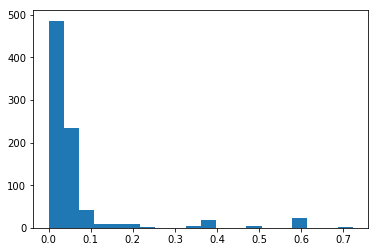

CPU times: user 1.92 s, sys: 72.7 ms, total: 2 s
Wall time: 2 s


In [24]:
%time pipe.supervise()

## Classify

In [25]:
%time pipe.classify()

Skipping grid search.


/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 8 has argument past max length for model:	[arg ends at index 102; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:35: UserWarning: Additional warnings of this nature will be suppressed.
  warnings.warn('Additional warnings of this nature will be suppressed.')
/Users/bradenjh/anaconda/envs/snorkel/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=92  #epochs=5  batch size=92
[reRNN] Epoch 0 (0.24s)	Average loss=0.694546	Dev F1=0.00
[reRNN] Epoch 1 (0.49s)	Average loss=0.654908	Dev F1=0.00
[reRNN] Epoch 2 (0.73s)	Average loss=0.562504	Dev F1=0.00
[reRNN] Epoch 3 (0.98s)	Average loss=0.469502	Dev F1=0.00
[reRNN] Epoch 4 (1.22s)	Average loss=0.490283	Dev F1=0.00
[reRNN] Training done (1.26s)


/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 37 has argument past max length for model:	[arg ends at index 199; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


[reRNN] Model saved as <discriminative_spouse>
### [7.2] Evaluate generative model (opt_b=0.1)
### Done in 0.0s.

### [7.3] Evaluate discriminative model (opt_b=0.1)
### Done in 0.2s.

      Coverage  F1 Score  Precision    Recall
Disc       1.0  0.170732   0.093333  1.000000
Gen        1.0  0.750000   0.666667  0.857143
CPU times: user 11.5 s, sys: 2.16 s, total: 13.7 s
Wall time: 6.3 s


/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 5 has argument past max length for model:	[arg ends at index 103; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


## Compare to Traditional Supervision

Note: if running in debug mode, traditional supervision will likely fail, as there aren't enough gold labels loaded to use.

In [26]:
config['supervision'] = 'traditional'
config['max_train'] = 1000

Requested 1000 traditional labels. Using 8 instead...


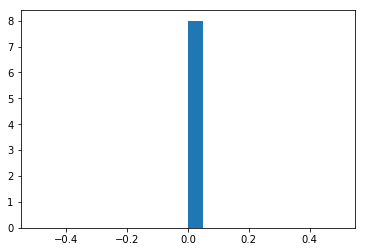

In [27]:
pipe.supervise(config=config)

In [ ]:
pipe.classify()

## Adding More Explanations

In [ ]:
train_candidates = session.query(candidate_class).filter(
    candidate_class.split == 0).all()

In [ ]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(train_candidates[500:600], session, n_per_page=3, height=300)
sv

In [ ]:
from snorkel.contrib.babble import Explanation

babbler.add_explanations(
    Explanation(
        label=False,
        condition="'role as' is between arg 1 and arg 2",
        candidate=sv.get_selected()
    )
)